# Analisi Dataset 

## Preparazione dell ambiente

Carico il drive e mi sposto nella cartella del progetto

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir(r"drive/MyDrive/Colab Notebooks/tirocinio/tirocinio-autoencoder/datasets/dataset1")
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/tirocinio/tirocinio-autoencoder/datasets/dataset1


### Installo pacchetti mancanti

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install -U matplotlib==3.1.3
    !pip install --quiet scikit-misc
    !pip install pytorch-lightning
    !pip install scanpy
    #!pip install --quiet scvi-tools[tutorials]
    !pip install --quiet gdown
    #!pip install --quiet --upgrade seaborn==0.12
    !pip install --quiet bbknn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.6.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


### Importo i pacchetti necessari

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import torch
import pytorch_lightning as pl
import sys
sys.path.insert(0, "../../autoencoder/")

## Loading e preprocessing dataset

Carico i dati in formato **AnnData** e li salvo in un layer chiamato **counts**

In [ ]:
adata = an.read_h5ad("./counts.h5ad.gzip")
adata.layers["counts"] = adata.X.copy()
adata.X.shape

(68579, 32738)

In [ ]:
adata.X.shape

(68579, 32738)

Seleziono e visualizzo i geni con piu' alta varianza

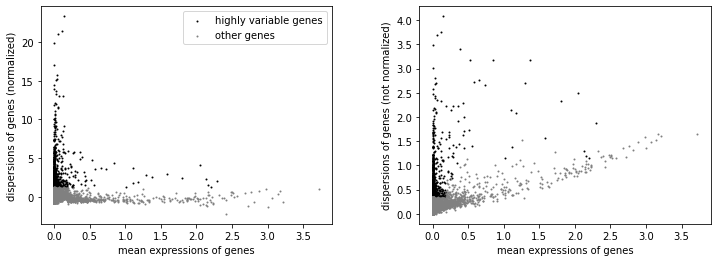

In [ ]:
#sc.pp.normalize_total(adata, target_sum=1e4) # scale each cell to a common library size
sc.pp.log1p(adata) # log(expression + 1)
adata.layers["log1"] = adata.X.copy()
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1000,
    # subset=True, # to automatically subset to the genes
    layer="log1",
    flavor="seurat"
)
sc.pl.highly_variable_genes(adata, save="high1000")
adata = adata[:, adata.var["highly_variable"]].copy()

### visualizzo usando umap 

Assegno i colori ad ogni categoria considerando anche la similarita tra i cluster

In [ ]:
adata.uns["celltype_colors"] = ["#b790d4", "#d648d7", "#601ef9", "#703be7", #910951 #purple
          "#5ca904", "#0cdc73", #green
          "#7f2b0a", #brown
          "#069af3", #azure
          "#ff000d", #red
          "#f9bc08", #yellow
          "#fe4b03"]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


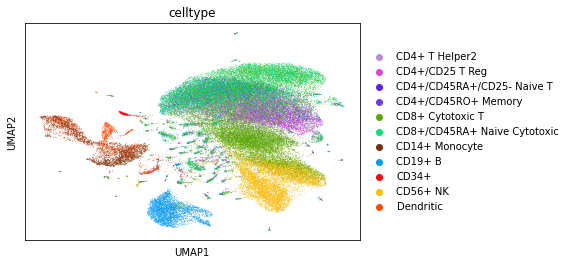

In [ ]:
adata.X = adata.layers["counts"].copy()
sc.pp.scale(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['celltype'], wspace=0.35, save="umap1000")
adata.layers["norm"] = adata.X.copy()
adata.X = adata.layers["counts"].copy()

## Autoencoder

### Preparo il dataloader

In [ ]:
from importlib import reload
import dataset
from dataset import MyAnDataset
import module
from module import AutoencoderNB
from torch.utils import data
reload(dataset)
reload(module)
import dataset
from dataset import MyAnDataset
import module
from module import AutoencoderNB
from torch.utils import data

In [ ]:
ds = MyAnDataset(adata, "counts", "norm")
dl = data.DataLoader(ds, shuffle=True, batch_size=128, pin_memory=True, num_workers=2)
next(iter(dl))

[tensor([[-0.0994, -0.1382, -0.1667,  ..., -0.0441, -0.0038, -0.1968],
         [-0.0994, -0.1382, -0.1667,  ..., -0.0441, -0.0038, -0.1968],
         [-0.0994, -0.1382, -0.1667,  ..., -0.0441, -0.0038, -0.1968],
         ...,
         [-0.0994, -0.1382, -0.1667,  ..., -0.0441, -0.0038, -0.1968],
         [-0.0994, -0.1382, -0.1667,  ..., -0.0441, -0.0038, -0.1968],
         [-0.0994, -0.1382, -0.1667,  ..., -0.0441, -0.0038, -0.1968]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])]

### Creo il modello

In [ ]:
autoencoder = AutoencoderNB(n_input=adata.n_vars, n_latent=24, layers_dim=[128, 64, 64], library_layers_dim=[128, 128])

## Alleno il modello

In [ ]:
logger = pl.loggers.CSVLogger("log", name="train_1000")
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=20, logger=logger)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(autoencoder, train_dataloaders=dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | MyEncoder  | 143 K 
1 | decoder   | MyDecoder  | 145 K 
2 | l_encoder | MyFCLayers | 144 K 
-----------------------------------------
434 K     Trainable params
0         Non-trainable params
434 K     Total params
1.736     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
torch.save(autoencoder.state_dict(), "./epoch=20_statedict_1000.pt")

## Analizzo i risultati

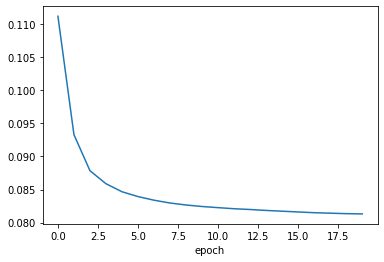

In [ ]:
history = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv", index_col="epoch")
axe=history["nb_metric"].plot.line()
#axe.set_ylim((1000,1025))

In [ ]:
dl = torch.utils.data.DataLoader(ds, batch_size=128)
predictions = trainer.predict(autoencoder, dl)
predictions = np.vstack([batch[0] for batch in predictions])
predictions.shape

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 536it [00:00, ?it/s]

(68579, 24)

## Analisi spazio latente

In [ ]:
import plot
import seaborn as sns
from plot import joinplot_pca
reload(plot)
reload(sns)

<module 'seaborn' from '/usr/local/lib/python3.8/dist-packages/seaborn/__init__.py'>

In [ ]:
adata_latent = an.AnnData(predictions)
adata_latent.var_names = [f"latent{i}" for i in range(predictions.shape[1])]
adata_latent.obs_names = adata.obs_names

In [ ]:
adata_latent.uns["celltype_colors"] = ["#b790d4", "#d648d7", "#601ef9", "#703be7", #910951 #purple
          "#5ca904", "#0cdc73", #green
          "#7f2b0a", #brown
          "#069af3", #azure
          "#ff000d", #red
          "#f9bc08", #yellow
          "#fe4b03"]

In [ ]:
adata_latent.obs["celltype"] = adata.obs["celltype"]

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


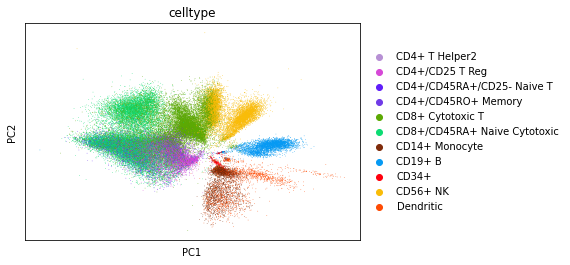

In [ ]:
sc.pp.pca(adata_latent, n_comps=2)
sc.pl.pca(adata_latent, color='celltype', save="1000")

In [ ]:
sc.pp.neighbors(adata_latent)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


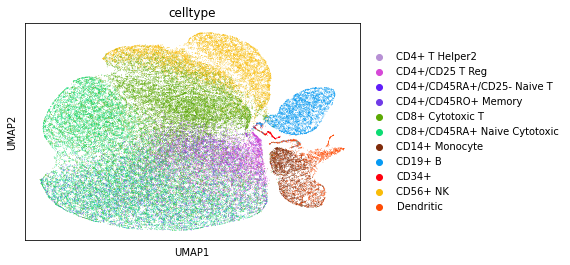

In [ ]:
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color=['celltype'], wspace=0.35, save="umap_latent1000")